# **Part 1 | Constructing ESG Factor**

### Importing Packages

In [59]:
import pandas as pd
import os

#Inspecting Factor
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter

# **Part I: Creating Factor**

### Importing & Preparing Data

#### Stock Returns

In [36]:
stock_returns = pd.read_excel("__data/Stock_Return_Data_Wide_Format.xlsx", "ReturnTotal")

In [37]:
#Divides Stock Return values by 100 to get decimal values
stock_returns.loc[:, stock_returns.columns != "Date"] = stock_returns.loc[:, stock_returns.columns != "Date"].apply(lambda x: x / 100)

#Set Date column as date
stock_returns["Date"] = pd.to_datetime(stock_returns["Date"])
stock_returns['Date'] = stock_returns["Date"].dt.date

#Set Date column as Index
stock_returns.set_index("Date", inplace=True)

In [41]:
stock_returns.head()

,A.N,AA.N,AAL.OQ,AAON.OQ,AAP.N,AAPL.OQ,AAT.N,ABBV.N,ABCB.N,ABG.N,...,YETI.N,YOU.N,YUM.N,ZBH.N,ZBRA.OQ,ZD.OQ,ZI.OQ,ZION.OQ,ZTS.N,ZWS.N
Date,,,,,,,,,,,,,,,,,,,,,
2009-01-31,0.156750,NaN,NaN,-0.132184,-0.027340,0.056005,NaN,NaN,-0.353586,-0.216630,...,NaN,NaN,-0.085414,-0.099456,-0.169299,-0.022954,NaN,-0.391269,NaN,NaN
2009-02-28,-0.232854,NaN,NaN,-0.143488,0.168653,-0.009098,NaN,NaN,-0.351175,-0.203911,...,NaN,NaN,-0.081761,-0.037912,0.043969,-0.043412,NaN,-0.370291,NaN,NaN
2009-03-31,0.108147,NaN,NaN,0.167526,0.075598,0.177024,NaN,NaN,-0.052314,0.512281,...,NaN,NaN,0.045662,0.042262,0.082527,0.168713,NaN,0.049093,NaN,NaN
2009-04-30,0.188029,NaN,NaN,0.075055,0.064995,0.197013,NaN,NaN,0.390658,1.243619,...,NaN,NaN,0.221622,0.205205,0.117245,0.095934,NaN,0.111902,NaN,NaN
2009-05-31,-0.001643,NaN,NaN,0.067762,-0.026514,0.079313,NaN,NaN,-0.042748,-0.017580,...,NaN,NaN,0.038381,0.012730,0.027294,-0.070446,NaN,0.254319,NaN,NaN


#### ESG Scores

In [48]:
esg_scores = pd.read_excel("__data/Stock_ESG_Data_Wide_Format.xlsx", "ESG")

In [49]:
#Set Date column as date
esg_scores["Date"] = pd.to_datetime(esg_scores["Date"])
esg_scores['Date'] = esg_scores["Date"].dt.date

#Set Date column as Index
esg_scores.set_index("Date", inplace=True)

esg_scores = esg_scores[esg_scores.index >= pd.to_datetime("2009-01-01").date()]

#Fill missing rows with previous values for esg score
esg_scores.fillna(method='ffill', inplace=True)

<ipython-input-49-d126a9c08feb>:11: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  esg_scores.fillna(method='ffill', inplace=True)


In [52]:
#The data between returns and ESG doesn't always match! Therefore we only keep matching columns
common_columns = esg_scores.columns.intersection(stock_returns.columns)
esg_scores = esg_scores[common_columns]

In [53]:
esg_scores.head()

,A.N,AA.N,AAL.OQ,AAON.OQ,AAP.N,AAPL.OQ,AAT.N,ABBV.N,ABCB.N,ABG.N,...,YETI.N,YOU.N,YUM.N,ZBH.N,ZBRA.OQ,ZD.OQ,ZI.OQ,ZION.OQ,ZTS.N,ZWS.N
Date,,,,,,,,,,,,,,,,,,,,,
2009-01-31,NaN,NaN,NaN,NaN,29.302437,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2009-02-28,NaN,NaN,NaN,NaN,29.302437,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2009-03-31,NaN,NaN,NaN,NaN,29.302437,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2009-04-30,NaN,NaN,NaN,NaN,29.302437,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2009-05-31,NaN,NaN,NaN,NaN,29.302437,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Calculating Portfolio - Functions

In [29]:
#Function Returns the Portfolio with the ESG Score of a certain percentile for each date
def getESGScorePercentile(esg_score_data, percentile, high = True):
    stock_list = []

    #Loops over each date
    for date in esg_score_data.index:
        esg_scores = esg_score_data.loc[date] #Gets corresponding esg scores
        esg_scores = esg_scores.dropna(axis=0) #Drops any missing values

        #Drops Date column as we don't want to look at this
        esg_scores = esg_scores.drop(columns = ["Date"])

        #Creates Portfolio
        if high:
            percentile_stocks = esg_scores.nlargest(int(len(esg_scores) * percentile / 100)).index.tolist()
        else:
            percentile_stocks = esg_scores.nsmallest(int(len(esg_scores) * percentile / 100)).index.tolist()

        #Counts stocks in portfolio
        count = len(percentile_stocks)

        #Appends to list
        stock_list.append((date, percentile_stocks, count))

    #Creates new dataframe
    stock_list_dataframe = pd.DataFrame(stock_list, columns=['Date', 'Stock_List', 'Stock_Count'])
    stock_list_dataframe.set_index("Date", inplace = True)

    #Returns dataframe
    return stock_list_dataframe

#Calculates POrtfolio return for a specific date & list of stocks
def getPortfolioReturn(return_data, date, list_stocks):
    returns = return_data.loc[date]
    returns = returns[list_stocks]

    return returns

#Calculates Return history
def calculateReturnHistory(return_data, portfolio_data, column_name_return, column_name_count):

    average_returns = []

    #Loops over each date
    for date in portfolio_data.index:

        #Gets list of stocks & count of stocks
        currentStockList = portfolio_data.loc[date]["Stock_List"]
        currentStockCount = portfolio_data.loc[date]["Stock_Count"]

        #Gets return of list of stocks at current date
        stock_returns = getPortfolioReturn(return_data, date, currentStockList)

        #Calculates average return (EQUAL WEIGHTED)
        if len(stock_returns) > 0:
            average_portfolio_return = stock_returns.mean()
        else:
            average_portfolio_return = float('nan')

        #Adds return to list
        average_returns.append((date, average_portfolio_return, currentStockCount))

    #Returns dataframe
    return pd.DataFrame(average_returns, columns=["Date", column_name_return, column_name_count])

In [68]:
#Returns dataframe containing the ESG Portfolios for each date
highest_stocks = getESGScorePercentile(esg_scores, 25, high = True)
lowest_stocks = getESGScorePercentile(esg_scores, 25, high = False)

#Calculates the Average Return for each Portfolio at each Date
highest_stocks_average_return = calculateReturnHistory(stock_returns, highest_stocks, "Average_Return_High", "Count_High")
lowest_stocks_average_return = calculateReturnHistory(stock_returns, lowest_stocks, "Average_Return_Low", "Count_Low")

#Merges Data together to have the data in one dataframe
return_history = pd.merge(highest_stocks_average_return, lowest_stocks_average_return, on='Date', how='outer')

#Calculates Factor for each Date
return_history["ESG_Factor"] = return_history["Average_Return_Low"] - return_history["Average_Return_High"]

return_history_used = return_history[return_history["Count_High"] > 50].copy() #Only look at diversified portfolios

#Exports Data as CSV
return_history_used.to_csv("__data/esg_factor_data.csv", index=False)

# **Part II: Inspecting Factor**

In [57]:
return_history_inspect = return_history[return_history["Count_High"] > 50].copy() #Only look at diversified portfolios

In [67]:
return_history.tail()

,Date,Average_Return_High,Count_High,Average_Return_Low,Count_Low,ESG_Factor
180,2024-01-31,-0.017469,371,-0.035805,371,-0.018336
181,2024-02-29,0.034943,371,0.048457,371,0.013514
182,2024-03-31,0.048524,371,0.030862,371,-0.017662
183,2024-04-30,-0.046839,371,-0.066778,371,-0.019939
184,2024-05-31,0.034909,371,0.057064,371,0.022154


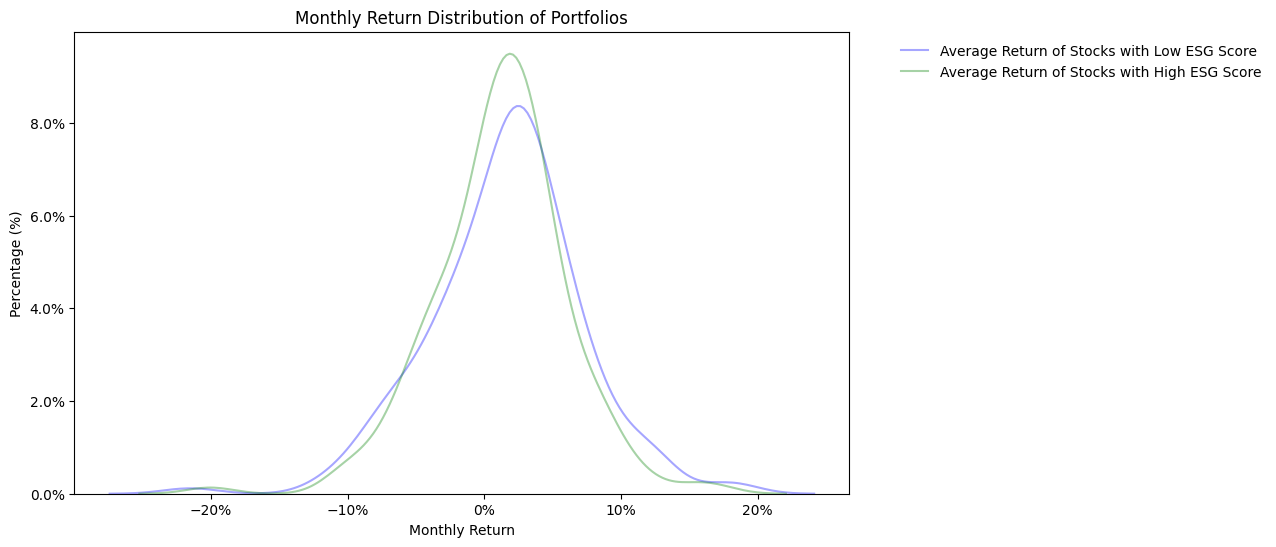

In [60]:
plt.figure(figsize=(10, 6), dpi=100)

sns.kdeplot(return_history_inspect['Average_Return_Low'], color='blue', label='Average Return of Stocks with Low ESG Score', fill=False, alpha=0.35)
sns.kdeplot(return_history_inspect['Average_Return_High'], color='green', label='Average Return of Stocks with High ESG Score', fill=False, alpha=0.35)

plt.gca().xaxis.set_major_formatter(PercentFormatter(xmax=1.0))
plt.gca().yaxis.set_major_formatter(PercentFormatter(xmax=100))

# Add labels and title
plt.xlabel('Monthly Return')
plt.ylabel('Percentage (%)')
plt.title('Monthly Return Distribution of Portfolios')

# Add legend
plt.legend(bbox_to_anchor = (1.05, 1), loc = "upper left", frameon = False)

#Remove Grid
plt.grid(visible = False)

# Show plot
plt.show()

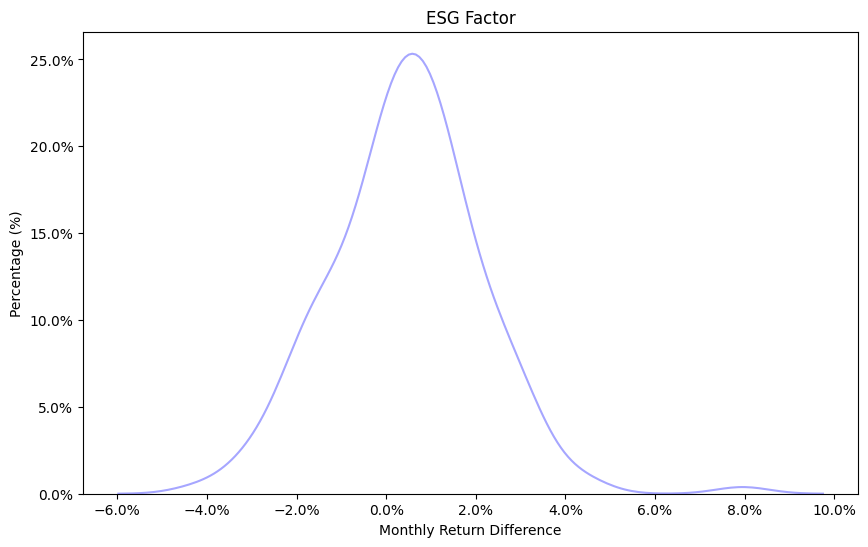

In [61]:
plt.figure(figsize=(10, 6), dpi=100)

sns.kdeplot(return_history_inspect['ESG_Factor'], color='blue', fill=False, alpha=0.35)

plt.gca().xaxis.set_major_formatter(PercentFormatter(xmax=1.0))
plt.gca().yaxis.set_major_formatter(PercentFormatter(xmax=100))

# Add labels and title
plt.xlabel('Monthly Return Difference')
plt.ylabel('Percentage (%)')
plt.title('ESG Factor')

#Remove Grid
plt.grid(visible = False)

# Show plot
plt.show()

In [62]:
initial_investment = 100

# Calculate cumulative growth factor for each stock
return_history_inspect["Portfolio_Value_High"] = initial_investment * (1 + return_history_inspect["Average_Return_High"]).cumprod()
return_history_inspect["Portfolio_Value_Low"] = initial_investment * (1 + return_history_inspect["Average_Return_Low"]).cumprod()

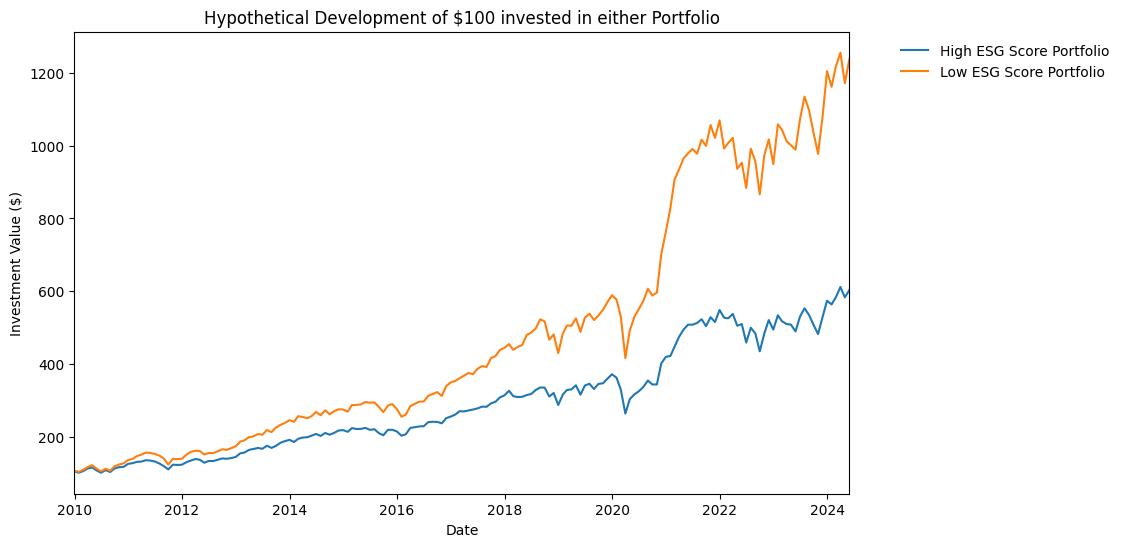

In [63]:
# Plot the investment growth for each stock over time
plt.figure(figsize=(10, 6))

sns.lineplot(y = "Portfolio_Value_High", x = "Date", label = "High ESG Score Portfolio", data = return_history_inspect)
sns.lineplot(y = "Portfolio_Value_Low", x = "Date", label = "Low ESG Score Portfolio", data = return_history_inspect)

# Adding labels and title
plt.title("Hypothetical Development of $100 invested in either Portfolio")

plt.xlabel("Date")
plt.ylabel("Investment Value ($)")

plt.legend(bbox_to_anchor = (1.05, 1), loc = "upper left", frameon = False)

plt.grid(visible = False)
plt.xlim(return_history_inspect["Date"].min(), return_history_inspect["Date"].max())

plt.show()